In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression, load_diabetes, fetch_california_housing
from sklearn import preprocessing
from sklearn.utils import resample
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import torch

plt.style.use('ggplot')

/Users/shamsi/anaconda3/envs/hetfl/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-02-24 16:32:01.490587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Generate Data

In [13]:
M = np.random.normal(0, 1, size=(5, 5)) 
cov = np.dot(M, M.T)
cov

array([[ 6.66073847, -3.58919833, -1.43403608,  4.02063382, -2.35208034],
       [-3.58919833,  4.99977664,  0.29441039, -2.87144061,  2.03893449],
       [-1.43403608,  0.29441039,  3.22518648, -4.56407827,  0.0144617 ],
       [ 4.02063382, -2.87144061, -4.56407827, 10.09254221, -2.12820129],
       [-2.35208034,  2.03893449,  0.0144617 , -2.12820129,  5.01582125]])

In [21]:
n_features = 3
mean = np.random.normal(0, 1.0, size=(n_features,)) 
M = np.random.normal(0, 1, size=(n_features, n_features)) 
cov = np.dot(M, M.T)

# Sample datapoints from multivar Gaussian
X = np.random.multivariate_normal(mean, cov, (10,))
cov, X

(array([[ 5.88223463, -3.72729594,  3.09640328],
        [-3.72729594,  3.06513777, -1.34205201],
        [ 3.09640328, -1.34205201,  2.787487  ]]),
 array([[-1.81559118, -1.10728497,  1.33750443],
        [-5.14443398, -0.58278413, -2.78898297],
        [-1.07216096, -1.29043113,  2.082257  ],
        [-3.30501628,  0.79618201,  1.39490462],
        [-4.16835681,  0.24496543, -1.13316906],
        [-0.59543074, -1.37077122,  2.69556721],
        [-1.969848  , -1.75606875,  0.987453  ],
        [-3.92174823, -0.27732949, -1.21448447],
        [-6.06361733, -0.20642085, -3.53060034],
        [-3.80823045,  1.45469724,  1.37997827]]))

In [8]:
np.random.seed(0)
np.random.normal(0, 1.0, size=(5, 5))

array([[ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799],
       [-0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ],
       [ 0.14404357,  1.45427351,  0.76103773,  0.12167502,  0.44386323],
       [ 0.33367433,  1.49407907, -0.20515826,  0.3130677 , -0.85409574],
       [-2.55298982,  0.6536186 ,  0.8644362 , -0.74216502,  2.26975462]])

In [11]:
np.zeros((5,))

array([0., 0., 0., 0., 0.])

In [12]:
np.random.seed(0)
np.random.multivariate_normal(np.zeros((5,)), np.eye(5), (5,))

array([[ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799],
       [-0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ],
       [ 0.14404357,  1.45427351,  0.76103773,  0.12167502,  0.44386323],
       [ 0.33367433,  1.49407907, -0.20515826,  0.3130677 , -0.85409574],
       [-2.55298982,  0.6536186 ,  0.8644362 , -0.74216502,  2.26975462]])

In [2]:
# Create synthetic datasets
def get_data(n_clusters, n_ds, n_samples, n_features, noise_scale=1.0):
    """
    :param noise: scale of normal distribution used to generate data noise
    """
    
    ds_train = []
    ds_val = []
    cluster_labels = []
    true_weights = np.zeros((n_clusters, n_features))
    
    for i in range(n_clusters):
        # Sample mean vector for cluster i 
        #mean = (np.random.default_rng().uniform(low=-10.0, high=10.0, size=n_features))
        mean = np.random.normal(0, 1.0, size=(n_features,)) 
        
        # Create covariance matrix for cluster i 
        # Sample values for a square matrix 
        M = np.random.normal(0, 1.0, size=(n_features, n_features)) 
        # Create symmetric and positive-semidefinite matrix
        cov = np.dot(M, M.T)
        # Sample true weight vector for cluster i
        w = np.random.normal(0, 1.0, size=(n_features,1))
        true_weights[i] = w.reshape(-1,)

        for j in range(n_ds):
            # Sample datapoints from multivar Gaussian
            X = np.random.multivariate_normal(mean, cov, (1000,))
            
            # Sample noise for n_samples datapoints
            noise = np.random.normal(loc=0.0, scale=noise_scale, size=(1000, 1))
            
            y = X@w + noise
            
            X_train, y_train = resample(X, y, n_samples=n_samples)
            X_val, y_val = resample(X, y, n_samples=100)

            
            # Scale features
            scaler = preprocessing.StandardScaler().fit(X_train)
            
            X_train = scaler.transform(X_train)
            X_val = scaler.transform(X_val)
            
            ds_train.append( (X_train, y_train) )
            ds_val.append( (X_val, y_val) )
            
            cluster_labels.append(i)

    return ds_train, ds_val, cluster_labels, true_weights

In [3]:
# Create "real" datasets (toy ds from sklearn)
def get_mixed_data(n_clusters, n_ds, n_samples, n_features):
    ds_train = []
    ds_val = []
    cluster_labels = []

    for i in range(n_clusters):
        if i==0:
            for j in range(n_ds):
                X, y = make_regression(1000, n_features)
                
                X_train, y_train = resample(X, y, n_samples=n_samples)
                X_val, y_val = resample(X, y, n_samples=100)
                
                scaler = preprocessing.StandardScaler().fit(X_train)

                X_train = scaler.transform(X_train)
                X_val = scaler.transform(X_val)

                ds_train.append( (X_train, y_train.reshape(-1,1)) )
                ds_val.append( (X_val, y_val.reshape(-1,1)) )

                cluster_labels.append(i)
                
        elif i==1:
            for j in range(n_ds):
                X, y = fetch_california_housing(return_X_y=True)
                
                X_train, y_train = resample(X, y, n_samples=n_samples)
                X_val, y_val = resample(X, y, n_samples=100)
                
                scaler = preprocessing.StandardScaler().fit(X_train)

                X_train = scaler.transform(X_train)
                X_val = scaler.transform(X_val)

                ds_train.append( (X_train[:, :n_features], y_train.reshape(-1,1)) )
                ds_val.append( (X_val[:, :n_features], y_val.reshape(-1,1)) )

                cluster_labels.append(i)
            
        elif i==2:
            for j in range(n_ds):
                X, y = load_diabetes(return_X_y=True)
                
                X_train, y_train = resample(X, y, n_samples=n_samples)
                X_val, y_val = resample(X, y, n_samples=100)
                
                scaler = preprocessing.StandardScaler().fit(X_train)

                X_train = scaler.transform(X_train)
                X_val = scaler.transform(X_val)

                ds_train.append( (X_train[:, :n_features], y_train.reshape(-1,1)) )
                ds_val.append( (X_val[:, :n_features], y_val.reshape(-1,1)) )

                cluster_labels.append(i)

    return ds_train, ds_val, cluster_labels

In [157]:
def get_simpsons(n_clusters, n_ds, n_samples, n_features=1):
    # http://www.degeneratestate.org/posts/2017/Oct/22/generating-examples-of-simpsons-paradox/
    
    ds_train = []
    ds_val = []
    cluster_labels = []
    
    for i in range(n_clusters):
        overall_cov = 3*np.array([[1,0.9], [0.9,1]])
        means = np.random.multivariate_normal(mean=[0,0], cov=overall_cov, size=n_ds)

        covs = [np.random.uniform(0.2,0.8) for _ in range(n_ds)]
        covs = [np.array([[1,-c], [-c,1]]) for c in covs]

        for mean, cov in zip(means, covs):
            data = np.random.multivariate_normal(mean=mean, cov=cov, size=1000)
            X, y = data[:,0], data[:,1]
            X, y = X.reshape(-1,1), y.reshape(-1,1)
                
            X_train, y_train = resample(X, y, n_samples=n_samples)
            X_val, y_val = resample(X, y, n_samples=100)
            
            ds_train.append( (X_train, y_train) )
            ds_val.append( (X_val, y_val) )
            
            cluster_labels.append(i)

    return ds_train, ds_val, cluster_labels

In [158]:
ds_train, ds_val, cluster_labels = get_simpsons(n_clusters, n_ds, n_samples=5, n_features=1)

In [150]:
len(ds_train), ds_train[0][0].shape

(15, (50, 1))

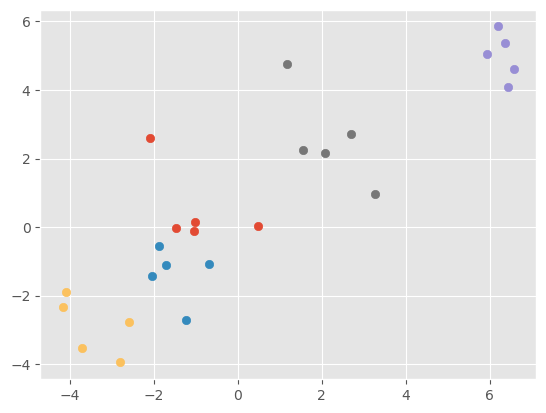

In [159]:
for ds in ds_train[5:10]:
    plt.scatter(ds[0], ds[1])

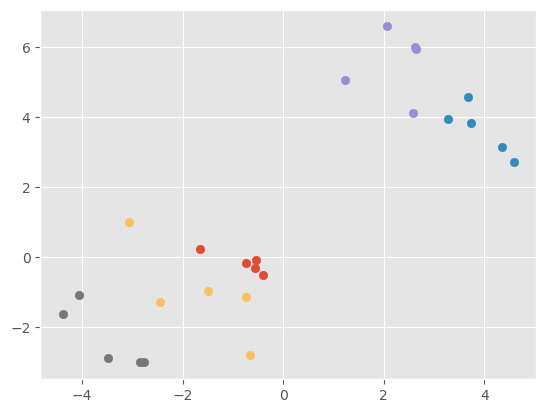

In [156]:
for ds in ds_train[:5]:
    plt.scatter(ds[0], ds[1])

In [4]:
# Create test data, univar Gaussian
def get_shared_data(n_samples, n_features):
    
    rng = np.random.RandomState(0)
    w = np.random.normal(loc=0.0, scale=1, size=(n_features, 1))
    noise = np.random.normal(loc=0.0, scale=1, size=(n_samples, 1))

    X = rng.randn(n_samples, n_features)
    y = X@w + noise

    return X, y

# Implementation of "Algorithm 2 FedRelax Least-Squares Regression" with Pytorch

In [142]:
class Optimize(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        
    # Model prediction with tracking gradients
    def forward(self, x):
        if type(x) != torch.Tensor:
            x = torch.FloatTensor(x)
            
        pred = self.model(x)
        return pred
    
    # Model prediction without tracking gradients
    def predict(self, x):
        if type(x) != torch.Tensor:
            x = torch.FloatTensor(x)
            
        with torch.no_grad():
            pred = self.model(x)
        return pred.detach().numpy() 

    def update(self, ds_train, ds_shared,  nodes_preds, A, regularizer_term):
        
        """
        nn - number of nodes
        m' - sample size of shared test data
        
        :param ds_train: local (node) dataset
        :param ds_shared: shared test dataset
        :param nodes_preds: predictions for ds_shared of all nodes, array of size (m', nn)
        :param A: row of a symmetric matrix A (weights of edges), array of size (nn,); A_ii=0 (zero diagonal)
        :param regularizer_term: lambda, float number
        
        """
        
        X, y = ds_train[0], ds_train[1]
        X_shared, y_shared = ds_shared[0], ds_shared[1]

        # Convert numpy arrays to torch tensors
        X, y = torch.FloatTensor(X), torch.FloatTensor(y)
        X_shared = torch.FloatTensor(X_shared)
        
        A = torch.from_numpy(A).float().reshape(-1,1)   # shape (nn,1)
        nodes_preds = torch.from_numpy(nodes_preds).float() # shape (m',nn)

        # Get predictions for local and shared test ds
        pred = self.model(X)
        pred_shared = self.model(X_shared)  # shape (m',1)
        
        # Set all gradient values to zeros
        self.model.zero_grad()  
        
        # Compute loss
        loss_local = self.criterion(y, pred)
        loss_GTV = torch.mean( ((pred_shared - nodes_preds)**2)@A )
        loss = loss_local + (regularizer_term/2)*loss_GTV
        
        # Backpropagate the gradients
        loss.backward()

        # Update parameters of the model using the chosen optimizer
        self.optimizer.step()

        return loss.item()

In [143]:
class Linreg_Torch(Optimize):
    def __init__(self, n_features, lr=0.001, bias=True):
        Optimize.__init__(self)
        
        # Define model
        if bias==False:
            self.model = torch.nn.Linear(n_features, 1, bias=False)
        else:
            self.model = torch.nn.Linear(n_features, 1)
            
        # Define Loss and Optimizer
        self.criterion = torch.nn.MSELoss(reduction='mean')
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=lr)
        
    def get_params(self):
        params = [layer.data for layer in self.model.parameters()][0].numpy()
        return params

In [7]:
class MLP_Torch(Optimize):
    def __init__(self, n_features, lr=0.001):
        Optimize.__init__(self)
        
        # Define model
        self.model = torch.nn.Sequential(
                    torch.nn.Linear(n_features, 10),
                    torch.nn.ReLU(),
                    torch.nn.Linear(10, 1)
        )

        # Define Loss and Optimizer
        self.criterion = torch.nn.MSELoss(reduction='mean')
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=lr)

### Manually check gradients [linear model]

In [8]:
from utils import fwd_check,  bckwd_check

# Create data
n_samples, n_features = 100, 10
ds, _, _, _ = get_data(n_clusters=1, n_ds=1, n_samples=n_samples, n_features=n_features)

# Create test data

rng = np.random.RandomState(0)
noise = rng.normal(loc=0.0, scale=1, size=n_samples)

X_test = rng.randn(n_samples, n_features)
y_test = 5 * X_test[:, 0] + (np.sin(10 * np.pi * X_test[:, 0]) - noise)
ds_test = X_test,  y_test.reshape(-1,1)

# Create linear model
linreg = Linreg_Torch(n_features)

# Check manually fwd step [only linear model!]
try:
    fwd_check(ds[0], linreg)
    print("Check passed!")
except: 
    print("Check failed!")
    

# Check manually bckw step [only linear model!]

# Edges weights for each nn, shape (nn,)
A = np.random.rand(3,)
# Predictions for a shared test ds, shape (m', nn)
preds_neighbors = np.random.rand(100, 3)

try:
    bckwd_check(ds[0], ds_test, preds_neighbors, A, linreg)
    print("Check passed!")
except: 
    print("Check failed!")

Check passed!
Check passed!


# Implementation of "Algorithm 1 FedRelax" via data augmentation (sample weight)

In [11]:
class Data_augmentation():
    
    @staticmethod
    def data_aug(ds_local, ds_test,  pred_test, A, regularizer_term):
        
        """
        nn - number of nodes
        m' - sample size of shared test data
        
        :param ds_local: local (node) dataset
        :param ds_test: shared test dataset
        :param pred_test: predictions for ds_test of all nodes, array of size (m', nn)
        :param A: row of a symmetric matrix A (weights of edges), array of size (nn,); A_ii=0 (zero diagonal)
        :param regularizer_term: lambda, float number
        
        """
        
        X, y = ds_local[0], ds_local[1].reshape(-1,)
        X_test, y_test = ds_test[0], ds_test[1].reshape(-1,)
        
        # Construct augmented dataset
        nn = pred_test.shape[1]
        
        X_test_repeat = np.tile(X_test, (nn,1))
        X_aug = np.concatenate((X, X_test_repeat), axis=0)
        y_aug = np.concatenate((y, pred_test.T.reshape(-1,)), axis=0)
        
        # Format edges' weights A and compute sample weight
        m = y.shape[0] 
        m_test = y_test.shape[0]    
    
        A_repeat = np.repeat(A, m_test, axis=0)
        sample_weight = np.concatenate((np.ones((m,)), np.ones((nn*m_test,))*(regularizer_term/2)*A_repeat))   

        return X_aug, y_aug, sample_weight

## Pytorch

In [12]:
class Optimize_aug(torch.nn.Module, Data_augmentation):
    def __init__(self):
        torch.nn.Module.__init__(self)
        
    # Model prediction with tracking gradients
    def forward(self, x):
        if type(x) != torch.Tensor:
            x = torch.FloatTensor(x)
            
        pred = self.model(x)
        return pred
    
    # Model prediction without tracking gradients
    def predict(self, x_test):
        if type(x_test) != torch.Tensor:
            x_test = torch.FloatTensor(x_test)
            
        with torch.no_grad():
            pred = self.model(x_test)
        return pred.detach().numpy() 

    def update(self, ds_local, ds_test,  pred_test, A, regularizer_term):
        
        """
        nn - number of nodes
        m' - sample size of shared test data
        
        :param ds_local: local (node) dataset
        :param ds_test: shared test dataset
        :param pred_test: predictions for ds_test of all nodes, array of size (m', nn)
        :param A: row of a symmetric matrix A (weights of edges), array of size (nn,); A_ii=0 (zero diagonal)
        :param regularizer_term: lambda, float number
        
        """
        # Create augmented dataset
        X_aug, y_aug, sample_weight = self.data_aug(ds_local, ds_test,  pred_test, A, regularizer_term)
        
        # Convert numpy arrays to torch tensors
        X_aug, y_aug = torch.FloatTensor(X_aug), torch.FloatTensor(y_aug)
        sample_weight =  torch.FloatTensor(sample_weight)
        
        A = torch.from_numpy(A).float().reshape(-1,1)   # shape (nn,1)
        pred_test = torch.from_numpy(pred_test).float() # shape (m',nn)
        
        # Set all gradient values to zeros
        self.model.zero_grad() 
        
        # Divide ds into smaller batches and do gradient accumulation
        bs = 100
        iters = math.ceil(len(X_aug)/bs)
        for i in range(iters):
                X_b, y_b = X_aug[i*bs:i*bs+bs], y_aug[i*bs:i*bs+bs]
                sw_b = sample_weight[i*bs:i*bs+bs]
                pred = self.model(X_b)
                loss = torch.sum(sw_b*(pred - y_b)**2) / bs
                loss.backward()

        # Update parameters of the model using the chosen optimizer
        self.optimizer.step()
        return loss.item()

In [13]:
class Linreg_Torch_aug(Optimize_aug):
    def __init__(self, n_features):
        Optimize_aug.__init__(self)
        
        # Define model
        self.model = torch.nn.Linear(n_features, 1)
        
        # Define Loss and Optimizer
        self.criterion = torch.nn.MSELoss(reduction='mean')
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=0.001)

In [14]:
class MLP_Torch_aug(Optimize_aug):
    def __init__(self, n_features):
        Optimize_aug.__init__(self)
        
        # Define model
        self.model = torch.nn.Sequential(
                    torch.nn.Linear(n_features, 10),
                    torch.nn.ReLU(),
                    torch.nn.Linear(10, 1)
        )

        # Define Loss and Optimizer
        self.criterion = torch.nn.MSELoss(reduction='mean')
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=0.001)

## Scikit-learn

In [15]:
from sklearn.linear_model import LinearRegression

class Linreg_Sklearn(LinearRegression, Data_augmentation):
    def __init__(self, **kwargs):
        LinearRegression.__init__(self, **kwargs)

    def update(self, ds_local, ds_test,  pred_test, A, regularizer_term):
        
        """
        nn - number of nodes
        m' - sample size of shared test data
        
        :param ds_local: local (node) dataset
        :param ds_test: shared test dataset
        :param pred_test: predictions for ds_test of all nodes, array of size (m', nn)
        :param A: row of a symmetric matrix A (weights of edges), array of size (nn,); A_ii=0 (zero diagonal)
        :param regularizer_term: lambda, float number
        
        """  
        # Get augmented dataset
        X_aug, y_aug, sample_weight = self.data_aug(ds_local, ds_test,  pred_test, A, regularizer_term)
        # Fit data
        self.fit(X_aug, y_aug, sample_weight=sample_weight)
        
        # Compute MSE
        preds = self.predict(X_aug)
        loss = np.mean((y_aug - preds)**2)

        return loss

In [16]:
from sklearn.tree import DecisionTreeRegressor

class DTReg(DecisionTreeRegressor, Data_augmentation):
    def __init__(self, **kwargs):
        DecisionTreeRegressor.__init__(self, **kwargs)

    def update(self, ds_local, ds_test,  pred_test, A, regularizer_term):
        
        """
        nn - number of nodes
        m' - sample size of shared test data
        
        :param ds_local: local (node) dataset
        :param ds_test: shared test dataset
        :param pred_test: predictions for ds_test of all nodes, array of size (m', nn)
        :param A: row of a symmetric matrix A (weights of edges), array of size (nn,); A_ii=0 (zero diagonal)
        :param regularizer_term: lambda, float number
        
        """  
        # Get augmented dataset
        X_aug, y_aug, sample_weight = self.data_aug(ds_local, ds_test,  pred_test, A, regularizer_term)
        # Fit data
        self.fit(X_aug, y_aug, sample_weight=sample_weight)
        
        # Compute MSE
        preds = self.predict(X_aug)
        loss = np.mean((y_aug - preds)**2)

        return loss

In [17]:
from sklearn.ensemble import RandomForestRegressor

class RFReg(RandomForestRegressor, Data_augmentation):
    def __init__(self, **kwargs):
        RandomForestRegressor.__init__(self, **kwargs)

    def update(self, ds_local, ds_test,  pred_test, A, regularizer_term):
        
        """
        nn - number of nodes
        m' - sample size of shared test data
        
        :param ds_local: local (node) dataset
        :param ds_test: shared test dataset
        :param pred_test: predictions for ds_test of all nodes, array of size (m', nn)
        :param A: row of a symmetric matrix A (weights of edges), array of size (nn,); A_ii=0 (zero diagonal)
        :param regularizer_term: lambda, float number
        
        """  
        # Get augmented dataset
        X_aug, y_aug, sample_weight = self.data_aug(ds_local, ds_test,  pred_test, A, regularizer_term)
        # Fit data
        self.fit(X_aug, y_aug, sample_weight=sample_weight)
        
        # Compute MSE
        preds = self.predict(X_aug)
        loss = np.mean((y_aug - preds)**2)

        return loss

## Keras

In [18]:
class MLP_Keras(Data_augmentation):
    def __init__(self, n_features):
        
        # Define model
        self.model = model = keras.Sequential(
            [
                layers.Dense(10, activation="relu", input_shape=(n_features,)),
                layers.Dense(1)
            ]
        )
        
        # Define Loss and Optimizer
        optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
        self.model.compile(loss="mean_squared_error", optimizer=optimizer)
        
    # Model prediction 
    def predict(self, x):
        return self.model(x).numpy()

        
    def update(self, ds_local, ds_test,  pred_test, A, regularizer_term):
        
        """
        nn - number of nodes
        m' - sample size of shared test data
        
        :param ds_local: local (node) dataset
        :param ds_test: shared test dataset
        :param pred_test: predictions for ds_test of all nodes, array of size (m', nn)
        :param A: row of a symmetric matrix A (weights of edges), array of size (nn,); A_ii=0 (zero diagonal)
        :param regularizer_term: lambda, float number
        
        """  
        # Get augmented dataset
        X_aug, y_aug, sample_weight = self.data_aug(ds_local, ds_test,  pred_test, A, regularizer_term)
        # Run a single gradient update on a single batch of data
        self.model.train_on_batch(X_aug, y_aug, sample_weight=sample_weight)
        
        # Compute MSE
        preds = self.predict(X_aug) 
        loss = np.mean((y_aug - preds)**2)

        return loss

# Training

## Building a graph network 

In [19]:
def build_graph(ds_train, ds_val, ds_shared, models):
    G = []
    for ds_t, ds_v, model in zip(ds_train, ds_val, models):
        G.append({ "model": model, "ds_train": ds_t, "ds_val": ds_v, "ds_shared": ds_shared}) 
        
    return G

def build_edges(G, cluster_labels, p_in = 0.8, p_out = 0.2):
    # Create network edges  with probability p_in for nodes within a cluster 
    # and probability p_out for nodes from different clusters
    # weights are the same for all edges A_ij = 1; for A_ii = 0

    nn = len(G)
    A = np.zeros((nn, nn))
    rows, cols = A.shape

    for i in range(rows):
        for j in range(cols):
            if i==j:
                A[i,j] = 0
            elif cluster_labels[i] == cluster_labels[j]:
                A[i,j] = np.random.binomial(n=1, p=p_in, size=5)[0] 
            else:
                A[i,j] = np.random.binomial(n=1, p=p_out, size=5)[0]

    # Create a symmetric matrix           
    A = np.tril(A) 
    A = A + A.T
    return A

## Training loop

In [20]:
def train(G, A, iters=1000, regularizer_term=0.01, verbose=False):   
    
    nnodes = len(G)                                # number of nodes in a graph
    m_shared = G[0]["ds_shared"][0].shape[0]       # sample size of the shared ds
    nodes_preds = np.zeros((m_shared, nnodes))       # init predictions on a shared ds
    # save predictions on a test set for iter 1, 500, 1000
    preds_list = []
    
    for i in range(iters):
        # Get predictions for a local and test datasets for each node 
        # Compute loss and update model
        for n in range(nnodes):
            ds_train = G[n]["ds_train"]
            ds_shared = G[n]["ds_shared"]
            model = G[n]["model"]
            loss = model.update(ds_train, ds_shared, nodes_preds, A[n], regularizer_term) 

        # Update predictions on a shared test set 
        nodes_preds = np.zeros((m_shared, nnodes)) 
        for n in range(nnodes):
            ds_train = G[n]["ds_train"]
            ds_shared = G[n]["ds_shared"]
            model = G[n]["model"]

            # updated model predictions
            pred_train = model.predict(ds_train[0])
            pred_shared = model.predict(ds_shared[0])
            # store preds on a shared ds
            nodes_preds[:, n] = pred_shared.reshape(-1,)
            # loss
            if verbose:
                print(f"Iteration {i+1}")
                print(f"Node {n+1}, Training Loss {np.mean((ds_train[1] - pred_train)**2): .2f}")
        if (i==1) | (i==iters/2-1) | (i==iters-1):
            preds_list.append(nodes_preds)
            
    # Compute MSE on local ds of trained models
    mse_train = np.zeros((nnodes,))
    mse_val = np.zeros((nnodes,))
    for n in range(nnodes):
        # node
        ds_train = G[n]["ds_train"]
        ds_val = G[n]["ds_val"]
        model = G[n]["model"]

        # model predictions
        pred_train = model.predict(ds_train[0])
        pred_val = model.predict(ds_val[0])
        
        mse_train[n] = np.mean((ds_train[1] - pred_train)**2)
        mse_val[n] = np.mean((ds_val[1] - pred_val)**2)
       
    return preds_list, mse_train, mse_val

## Models' parameters similarity [pytorch linear model only]

In [21]:
# Compute similarity between learnt weight vector of a linear model and true weight vector for all clusters
# Note - set bias=False for lin.model

def sq_eucl_dist(G, true_weights):
    dist = np.zeros((len(G), len(true_weights)))
    for i in range(len(G)):
        model_params = G[i]['model'].get_params()
        dist[i] = np.sum((model_params - true_weights)**2, axis=1)
    return dist

## Plotting functions

In [22]:
import matplotlib.pyplot as plt

# Plot MSE of predictions on a shared test set MSE(node_i, node_j)
def compute_mse(preds):
    nn = preds.shape[1]
    mse_node = np.zeros((nn,nn))

    for n in range(nn):
        node_pred = preds[:,n].reshape(-1,1)
        mse_node[n] = np.mean((node_pred - preds)**2, axis=0)

    # Plot MSE of predictions on a shared test set (averaged by cluster)
    mse_aver = np.zeros((n_clusters, n_clusters))

    for i in range(n_clusters):
        for j in range(n_clusters):
            mse_aver[i,j] = np.mean(mse_node[n_ds*i:n_ds*i+n_ds, n_ds*j:n_ds*j+n_ds])
    return mse_node, mse_aver

def plot_preds_similarity(A, preds_list):
    
    fig, axs = plt.subplots(1, 5, figsize=(10,6))
    # Plot edges weights
    im1 = axs[0].imshow(A, cmap="RdBu")
    
    for i, preds in enumerate(preds_list):
        mse_node, _ = compute_mse(preds)
        # Plot matrix of MSE values on shared test dataset of (node_i, node_j) for all nodes in G
        im = axs[i+1].imshow(mse_node, cmap="coolwarm")
        fig.colorbar(im, ax=axs[i+1], shrink=0.6, location='bottom')
        
    
    # Same but MSE averaged by cluster for last iter
    _, mse_aver = compute_mse(preds_list[-1])
    im5 = axs[-1].imshow(mse_aver, cmap="coolwarm")
    
    # Set titles
    axs[0].set_title("Edge weghts (matrix A)")
    axs[1].set_title("Iteration 1")
    axs[2].set_title("Iteration 500")
    axs[3].set_title("Iteration 1000")
    axs[4].set_title("Average MSE over clusters")

    fig.colorbar(im1, ax=axs[0], shrink=0.6, location='bottom')
    fig.colorbar(im5, ax=axs[4], shrink=0.6, location='bottom')
    
    return fig

## All models in a Graph are of one type

In [23]:
n_clusters, n_ds, n_samples, n_features = 3, 5, 100, 5
ds_shared = get_shared_data(n_samples, n_features)

### Pytorch

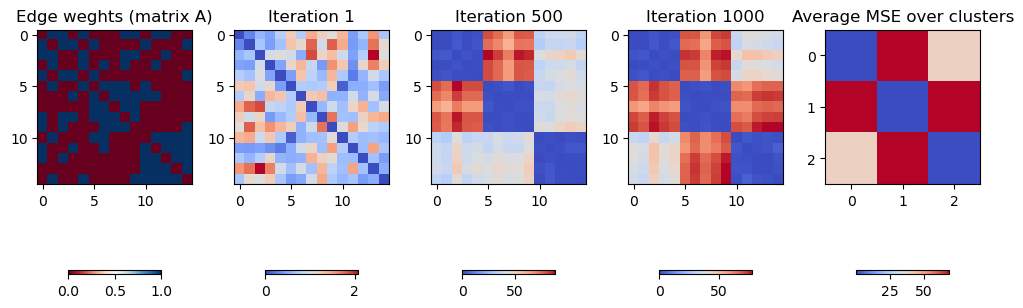

CPU times: user 7.68 s, sys: 32.3 ms, total: 7.72 s
Wall time: 7.78 s


In [24]:
%%time
#-----------------Pytorch Linear-------------------#

# Create a dataset
ds_train, ds_val, cluster_labels, true_weights = get_data(n_clusters, n_ds, n_samples, n_features, noise_scale=0)

# Create linear pytorch models
models = [Linreg_Torch(n_features, lr=0.01) for i in range(n_clusters*n_ds)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models)
A = build_edges(G, cluster_labels)
preds_list, mse_train, mse_val = train(G, A, iters=1000, regularizer_term=0, verbose=False)

fig = plot_preds_similarity(A, preds_list)
fig.tight_layout()
plt.show()

In [25]:
mse_train, mse_val

(array([0.00072344, 0.00049527, 0.00269931, 0.00096049, 0.00132835,
        0.02089077, 0.00501453, 0.00093183, 0.01279851, 0.00173572,
        0.02524524, 0.03192712, 0.02930626, 0.02964924, 0.02264394]),
 array([0.0009871 , 0.00062479, 0.00244524, 0.00119481, 0.00220314,
        0.03037162, 0.00617005, 0.00151208, 0.01452228, 0.00177139,
        0.01858551, 0.05195628, 0.03408621, 0.03800708, 0.01926598]))

In [ ]:
dist = sq_eucl_dist(G, true_weights)
plt.title("Squared Euclidian distance between learnt weight vector of a node and true vectors of 3 clusters")
plt.imshow(dist, cmap="coolwarm")
plt.colorbar()
plt.show()

In [ ]:
%%time
#-----------------Pytorch Linear - MIXED DATA-------------------#

# Create a dataset
ds_train, ds_val, cluster_labels = get_mixed_data(n_clusters, n_ds, n_samples, n_features)

# Create linear pytorch models
models = [Linreg_Torch(n_features) for i in range(n_clusters*n_ds)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models)
A = build_edges(G, cluster_labels)
preds_list, mse_train, mse_val = train(G, A, verbose=False)

fig = plot_preds_similarity(A, preds_list)
fig.tight_layout()
plt.show()

In [ ]:
%%time
#-----------------Pytorch MLP-------------------#

# Create a dataset
ds_train, ds_val, cluster_labels, true_weights = get_data(n_clusters, n_ds, n_samples, n_features)

# Create linear pytorch models
models = [MLP_Torch(n_features) for i in range(n_clusters*n_ds)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models)
A = build_edges(G, cluster_labels)
preds_list, mse_train, mse_val = train(G, A, verbose=False)

fig = plot_preds_similarity(A, preds_list)
fig.tight_layout()
plt.show()

In [ ]:
%%time
#-----------------Pytorch Linear data augmentation-------------------#

# Create a dataset
ds_train, ds_val, cluster_labels, true_weights = get_data(n_clusters, n_ds, n_samples, n_features)

# Create linear pytorch models
models = [Linreg_Torch_aug(n_features) for i in range(n_clusters*n_ds)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models)
A = build_edges(G, cluster_labels)
preds_list, mse_train, mse_val = train(G, A, verbose=False)

fig = plot_preds_similarity(A, preds_list)
fig.tight_layout()
plt.show()

In [ ]:
mse_local

In [ ]:
%%time
#-----------------Pytorch MLP data augmentation-------------------#

# Create a dataset
ds_train, ds_val, cluster_labels, true_weights = get_data(n_clusters, n_ds, n_samples, n_features)

# Create linear pytorch models
models = [MLP_Torch_aug(n_features) for i in range(n_clusters*n_ds)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models)
A = build_edges(G, cluster_labels)
preds_list, mse_train, mse_val = train(G, A, verbose=False)

fig = plot_preds_similarity(A, preds_list)
fig.tight_layout()
plt.show()

### Sklearn models

In [ ]:
%%time
#-----------------Sklearn LinReg data augmentation-------------------#

# Create a dataset
ds_train, ds_val, cluster_labels, true_weights = get_data(n_clusters, n_ds, n_samples, n_features)

# Create linear pytorch models
models = [Linreg_Sklearn() for i in range(n_clusters*n_ds)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models)
A = build_edges(G, cluster_labels)
preds_list, mse_train, mse_val = train(G, A, verbose=False)

fig = plot_preds_similarity(A, preds_list)
fig.tight_layout()
plt.show()

In [ ]:
mse_train, mse_val

In [ ]:
%%time
#-----------------Sklearn DT data augmentation-------------------#

# Create a dataset
ds_train, ds_val, cluster_labels, true_weights = get_data(n_clusters, n_ds, n_samples, n_features)

# Create models
models = [DTReg(max_depth=3, min_samples_leaf=5) for i in range(n_clusters*n_ds)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models)
A = build_edges(G, cluster_labels)
preds_list, mse_train, mse_val = train(G, A, verbose=False)

fig = plot_preds_similarity(A, preds_list)
fig.tight_layout()
plt.show()

In [ ]:
mse_train, mse_val

In [ ]:
%%time
#-----------------Sklearn RF data augmentation-------------------#

# Create a dataset
ds_train, ds_val, cluster_labels, true_weights = get_data(n_clusters, n_ds, n_samples, n_features)

# Create models
models = [RFReg(n_estimators=10, max_depth=3, min_samples_leaf=5) for i in range(n_clusters*n_ds)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models)
A = build_edges(G, cluster_labels)
preds_list, mse_train, mse_val = train(G, A, verbose=False)

fig = plot_test_preds(A, preds_test)
fig.tight_layout()
plt.show()

In [ ]:
mse_local

### Keras models

In [ ]:
%%time
#-----------------Keras MLP data augmentation-------------------#

# Create a dataset
ds_train, ds_val, cluster_labels, true_weights = get_data(n_clusters, n_ds, n_samples, n_features)

# Create linear pytorch models
models = [MLP_Keras(n_features) for i in range(n_clusters*n_ds)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models)
A = build_edges(G, cluster_labels)
preds_list, mse_train, mse_val = train(G, A, verbose=False)

fig = plot_test_preds(A, pred_tests)
fig.tight_layout()
plt.show()

In [ ]:
mse_local

## Models in a Graph are of one type within a cluster

In [ ]:
%%time

# Create a dataset
ds_train, ds_val, cluster_labels, true_weights = get_data(n_clusters, n_ds, n_samples, n_features)

# Create linear pytorch models
models = [Linreg_Torch_aug(n_features) for i in range(n_ds)] + [Linreg_Torch(n_features) for i in range(n_ds)] + [MLP_Torch(n_features) for i in range(n_ds)]

# Build a graph with nodes {model, dataset local, dataset test}
G = build_graph(ds_train, ds_val, ds_shared, models)
A = build_edges(G, cluster_labels)
preds_list, mse_train, mse_val = train(G, A, verbose=False)

fig = plot_test_preds(A, pred_tests)
fig.tight_layout()
plt.show()

In [ ]:
mse_local

## Models in a Graph are of mixed type within a cluster

# Effect of regularization term $\lambda$ on loss and sample size of a local dataset

In [130]:
def iter_params(config, mixed=False, simpsons=False, compute_dist=False):
    # Config
    n_clusters = config['n_clusters']
    n_ds = config['n_ds']
    n_features = config['n_features']
    noise_val = config['noise_val']
    
    reg_term_list = config['reg_term_list']
    n_samples_list = config['n_samples_list']
    repeat_times = config['repeat_times']
    
    models = config['models']
    ds_shared = config['ds_shared']

    m_shared = ds_shared[0].shape[0]
    nnodes = n_clusters*n_ds
    
    # Lists to store results of train() loop with hyperparams pairs {reg_term,n_samples} repeated `repeat_times` times
    mse_train_list = []
    mse_val_list = []
    nodes_preds_list = []
    dist_list = []

    for reg_term in reg_term_list:
        for n_samples in tqdm(n_samples_list):
            # Arrays to store intermediate results
            mse_train_array = np.zeros((repeat_times, nnodes))
            mse_val_array = np.zeros((repeat_times, nnodes))
            nodes_preds_array = np.zeros((repeat_times, m_shared, nnodes))
            dist_array = np.zeros((repeat_times, nnodes, n_clusters))
            
            # Repeat train() with hyperparams {reg_term,n_samples} 
            for i in range(repeat_times):
                # Create a dataset
                if mixed==True:
                    ds_train, ds_val, cluster_labels = get_mixed_data(n_clusters, n_ds, n_samples, n_features)
                elif simpsons==True:
                    ds_train, ds_val, cluster_labels = get_simpsons(n_clusters, n_ds, n_samples)
                else:
                    ds_train, ds_val, cluster_labels, true_weights = get_data(n_clusters, n_ds, n_samples, n_features, noise_val)

                # Build a graph with nodes {model, dataset local, dataset test}
                G = build_graph(ds_train, ds_val, ds_shared, models)
                A = build_edges(G, cluster_labels)
                preds_list, mse_train, mse_val = train(G, A, regularizer_term=reg_term, verbose=False)

                # Save preds on a shared set of last iteration
                nodes_preds_array[i] = preds_list[-1] 
                # Save mse on a local ds
                mse_train_array[i] = mse_train
                mse_val_array[i] = mse_val
                if compute_dist:
                    # only for G with pytorch lin.models
                    # compute dist b/learnt model's weight vector and true weight vector for each cluster 
                    dist = sq_eucl_dist(G, true_weights)
                    dist_array[i] = dist
                
            mse_train_list.append(mse_train_array)
            mse_val_list.append(mse_val_array)
            nodes_preds_list.append(nodes_preds_array)
            dist_list.append(dist_array) 
            
    return nodes_preds_list, mse_train_list, mse_val_list, dist_list

### Predictions 

In [27]:
def mse_local_mean(mse_local_list):
    """
    Average mse values for each node over repeatitions (`repeat_times` param)
    """
    mse_local_mean = []
    mse_local_std = []

    for mse_local in mse_local_list:
        mse_local_mean.append(np.mean(mse_local))
        std = np.std(np.mean(mse_local, axis=1))
        mse_local_std.append(std)

    return mse_local_mean, mse_local_std

### Weight vectors dist - only for pytorch lin.model (set bias=False)

In [28]:
def cluster_dist(dist):
    """
    For a set of nodes belonging to one cluster compute mean (squared) Euclidian distance:
    dist_in  - mean dist between true weight vector of a cluster c to which nodes belong to and weight vector learnt by the model.
    dist_out - same but, for other than c clusters.
    Finally, all dist_in, dist_out values are averaged. 
    :param dist: shape (n_nodes, n_clusters)
    Output is a tuple, where each element is a float number.
    """
    # for each set of nodes (from one cluster) compute mean dist with weight vector of cluster_in, cluster_out
    # store in these lists
    dist_in = []
    dist_out = []
    n_clusters = dist.shape[1]
    n_ds = int(dist.shape[0]/n_clusters)
    
    cluster_labels = []
    for i in range(n_clusters):
        cluster_labels = cluster_labels + n_ds*[i] 
    
    for c in range(n_clusters):
        # Array of clusters
        clusters = np.array(range(n_clusters))
        # Clusters which are different from current cluster c
        clusters_out = np.where(clusters!=c)
        # Indices of nodes belonging to a cluster c
        node_ind = np.where(np.array(cluster_labels)==c)
        # Mean dist within cluster
        dist_in.append(np.mean(dist[node_ind, c]))
        # Mean dist out of cluster
        dist_out.append(np.mean(dist[node_ind,:][:,:,clusters_out]))
    return np.mean(dist_in),  np.mean(dist_out)

def cluster_dist_mean(dist_list):
    """
    Average 
    :param dist_list: list of len=len(reg_term_list)*len(n_samples_list). 
    Each element of the list is of shape (repeat_times, nnodes, n_clusters)
    """
    dist_in_mean = []
    dist_out_mean = []

    for dist in dist_list:
        dist_in_list = []
        dist_out_list = []
        for e in dist:
            # for each repetition (`repeat_times`) compute dist (float numbers)
            dist_in, dist_out = cluster_dist(e)
            dist_in_list.append(dist_in)
            dist_out_list.append(dist_out)
        # compute mean across repetitions
        dist_in_mean.append(np.mean(dist_in_list))
        dist_out_mean.append(np.mean(dist_out_list))
    return dist_in_mean, dist_out_mean

In [29]:
def plot_cluster_dist(cluster_dist, reg_term_list, n_samples_list):
    
    n_regs = len(reg_term_list)
    n_sizes = len(n_samples_list)
    titles = ['Learnt w vs true w of a cluster_in', 'Learnt w vs true w of clusters_out']
    
    fig, axes = plt.subplots(1,2, figsize=(10,4))

    for j in range(2):
        for i in range(n_regs):
            axes[j].plot(n_samples_list, cluster_dist[j][i*n_sizes:i*n_sizes+n_sizes], label='Regularization term ' + str(reg_term_list[i]))

        axes[j].set_title(titles[j])
        axes[j].set_xlabel('Local dataset size')
        axes[j].set_ylabel('Sq.Euclidian distance')
        axes[j].set_xticks(n_samples_list)
        axes[j].legend()
    plt.show()

In [30]:
def plot_mse(mse_mean, mse_std, reg_term_list, n_samples_list):
    """
    """
    
    n_regs = len(reg_term_list)
    n_sizes = len(n_samples_list)
    
    for i in range(n_regs):
        y = mse_mean[i*n_sizes:i*n_sizes+n_sizes]
        y_err = mse_std[i*n_sizes:i*n_sizes+n_sizes]
        ax.errorbar(n_samples_list, y, yerr=y_err, label='Reg. term ' + str(reg_term_list[i]), lolims=True, linestyle='--')

    ax.set_xticks(n_samples_list)
    return ax

In [49]:
# Hyperparameters to try:
# sample size of a local dataset at each node
n_samples_list = [5, 50, 100]
# value of regularization term lambda
reg_term_list = [0.0, 0.01, 0.05, 0.1]
# repeat experiment number of times
repeat_times = 10
# noise scale for synthetic data
noise_val = 1.0

# Config
config = {}

n_clusters, n_ds, n_samples, n_features = 3, 5, 50, 5
ds_shared = get_shared_data(n_samples, n_features)

config['reg_term_list'] = reg_term_list
config['n_samples_list'] = n_samples_list
config['repeat_times'] = repeat_times 
config['noise_val'] = noise_val

config['n_clusters'] = n_clusters 
config['n_ds'] = n_ds 
config['n_features'] = n_features

config['ds_shared'] = ds_shared

## All models in a Graph are of one type

### Pytorch Linreg

#### Synthetic ds

In [ ]:
%%time
#-----------------Pytorch Linear-------------------#

# Create linear pytorch models
models = [Linreg_Torch(n_features, bias=False) for i in range(n_clusters*n_ds)]
config['models'] = models

nodes_preds_list, mse_train_list, mse_val_list, dist_list = iter_params(config, compute_dist=True)

# Average results of repeated experiments
cdm = cluster_dist_mean(dist_list)

In [ ]:
plot_cluster_dist(cdm, reg_term_list, n_samples_list)

In [32]:
%%time
#-----------------Pytorch Linear-------------------#

noise_vals = [0, 0.5, 1]
mse_noise = []

for noise_val in noise_vals:
    # Create linear pytorch models
    models = [Linreg_Torch(n_features) for i in range(n_clusters*n_ds)]
    config['models'] = models
    config['noise_val'] = noise_val
    
    nodes_preds_list, mse_train_list, mse_val_list, dist_list = iter_params(config)
    mse_train, mse_std_train = mse_local_mean(mse_train_list)
    mse_val, mse_std_val = mse_local_mean(mse_val_list)
    
    mse_noise.append( [(mse_train, mse_std_train), (mse_val, mse_std_val)] )

100%|██████████████████████████████████████████████████████████████████████████| 3/3 [04:07<00:00, 82.43s/it]

CPU times: user 41min 54s, sys: 5.06 s, total: 41min 59s
Wall time: 1h 23min 37s


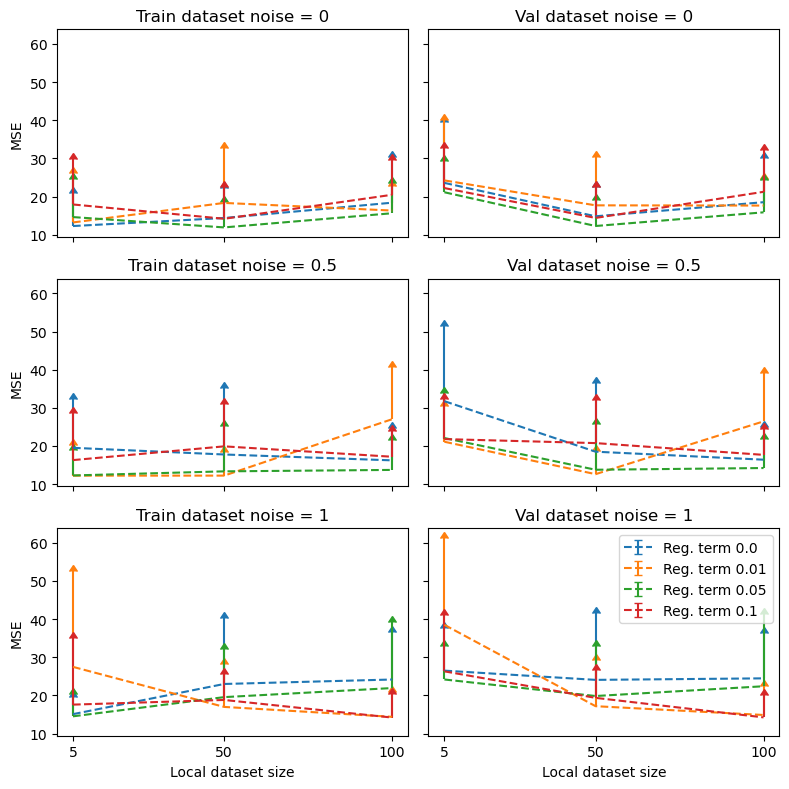

In [37]:
titles = ['Train dataset', 'Val dataset']

fig, axes = plt.subplots(len(noise_vals), 2, sharey=True, sharex=True, figsize=(8,8))

for i in range(len(noise_vals)):
    plot_list = mse_noise[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ' noise = ' + str(noise_vals[i]))

axes[0,0].set_ylabel ('MSE')
axes[1,0].set_ylabel ('MSE')
axes[2,0].set_ylabel ('MSE')

axes[-1,0].set_xlabel ('Local dataset size')
axes[-1,1].set_xlabel ('Local dataset size')
plt.legend()
fig.tight_layout()
plt.savefig("linreg_syn_ds_noise.png")
plt.show()

In [50]:
%%time
#-----------------Pytorch Linear-------------------#

lrates = [0.001, 0.01, 0.05]
mse_lrates = []

for lrate in lrates:
    # Create linear pytorch models
    models = [Linreg_Torch(n_features, lr=lrate) for i in range(n_clusters*n_ds)]
    config['models'] = models
    config['noise_val'] = 1
    
    nodes_preds_list, mse_train_list, mse_val_list, dist_list = iter_params(config)
    mse_train, mse_std_train = mse_local_mean(mse_train_list)
    mse_val, mse_std_val = mse_local_mean(mse_val_list)
    
    mse_lrates.append( [(mse_train, mse_std_train), (mse_val, mse_std_val)] )

100%|██████████████████████████████████████████████████████████████████████████| 3/3 [03:35<00:00, 71.73s/it]

CPU times: user 43min 48s, sys: 13.9 s, total: 44min 2s
Wall time: 45min 5s


In [52]:
import json

with open('linreg_syn_ds_lrate.json', 'w') as f:
    json.dump(mse_lrates, f)

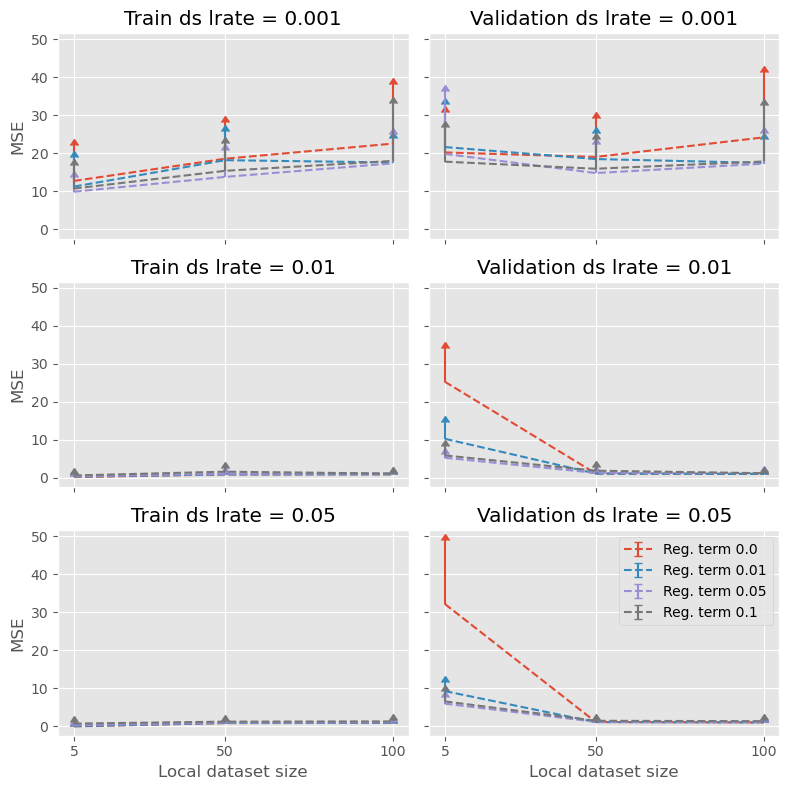

In [54]:
titles = ['Train ds', 'Validation ds']

fig, axes = plt.subplots(len(lrates), 2, sharey=True, sharex=True, figsize=(8,8))

for i in range(len(lrates)):
    plot_list = mse_lrates[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ' lrate = ' + str(lrates[i]))

axes[0,0].set_ylabel ('MSE')
axes[1,0].set_ylabel ('MSE')
axes[2,0].set_ylabel ('MSE')

axes[-1,0].set_xlabel ('Local dataset size')
axes[-1,1].set_xlabel ('Local dataset size')
plt.legend()
fig.tight_layout()
plt.savefig("linreg_syn_ds_lrate.png")
plt.show()

#### Toy ds

In [55]:
%%time
#-----------------Pytorch Linear - Mixed dataset-------------------#

lrates = [0.001, 0.01, 0.05]
mse_lrates = []

for lrate in lrates:
    # Create linear pytorch models
    models = [Linreg_Torch(n_features, lr=lrate) for i in range(n_clusters*n_ds)]
    config['models'] = models
    config['noise_val'] = 1
    
    nodes_preds_list, mse_train_list, mse_val_list, dist_list = iter_params(config, mixed=True)
    mse_train, mse_std_train = mse_local_mean(mse_train_list)
    mse_val, mse_std_val = mse_local_mean(mse_val_list)
    
    mse_lrates.append( [(mse_train, mse_std_train), (mse_val, mse_std_val)] )

100%|██████████████████████████████████████████████████████████████████████████| 3/3 [04:04<00:00, 81.48s/it]

CPU times: user 45min 4s, sys: 19.4 s, total: 45min 24s
Wall time: 46min 40s


In [56]:
import json

with open('linreg_toy_ds_lrate.json', 'w') as f:
    json.dump(mse_lrates, f)

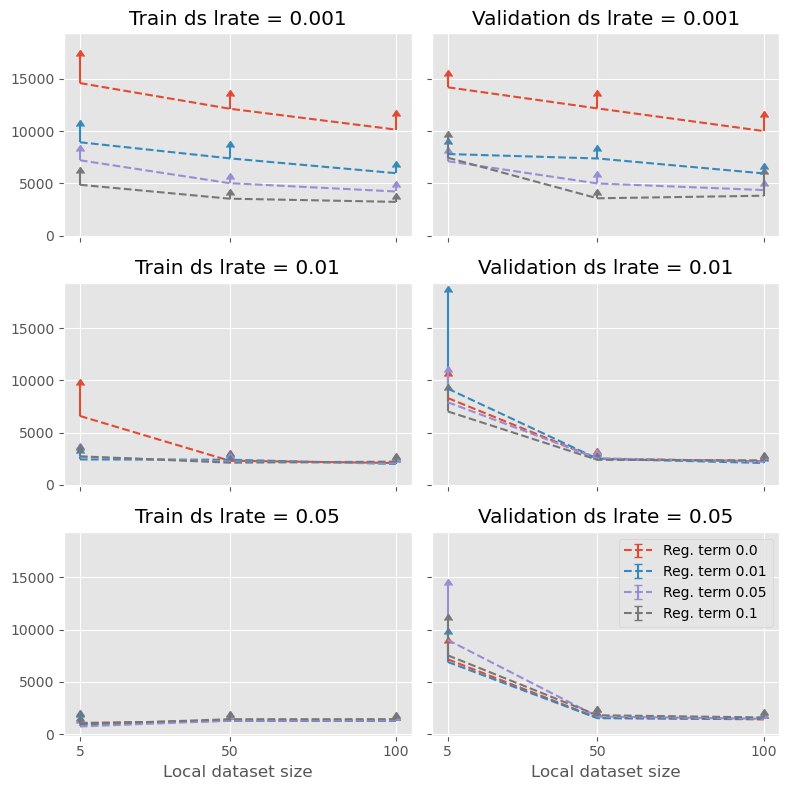

In [58]:
titles = ['Train ds', 'Validation ds']

fig, axes = plt.subplots(len(lrates), 2, sharey=True, sharex=True, figsize=(8,8))

for i in range(len(lrates)):
    plot_list = mse_lrates[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ' lrate = ' + str(lrates[i]))

axes[-1,0].set_xlabel ('Local dataset size')
axes[-1,1].set_xlabel ('Local dataset size')
plt.legend()
fig.tight_layout()
plt.savefig("linreg_toy_ds_lrate.png")
plt.show()

#### Simpsons ds

In [161]:
# Hyperparameters to try:
# sample size of a local dataset at each node
n_samples_list = [5, 50, 100]
# value of regularization term lambda
reg_term_list = [0.0, 0.01, 0.05, 0.1]
# repeat experiment number of times
repeat_times = 10
# noise scale for synthetic data
noise_val = 1.0

# Config
config = {}

n_clusters, n_ds, n_samples, n_features = 3, 5, 50, 1
ds_shared = get_shared_data(n_samples, n_features)

config['reg_term_list'] = reg_term_list
config['n_samples_list'] = n_samples_list
config['repeat_times'] = repeat_times 
config['noise_val'] = noise_val

config['n_clusters'] = n_clusters 
config['n_ds'] = n_ds 
config['n_features'] = n_features

config['ds_shared'] = ds_shared

In [162]:
%%time
#-----------------Pytorch Linear - Simpsons dataset-------------------#

lrates = [0.001, 0.01, 0.05]
mse_lrates = []

for lrate in lrates:
    # Create linear pytorch models
    models = [Linreg_Torch(n_features=1, lr=lrate) for i in range(n_clusters*n_ds)]
    config['models'] = models
    config['noise_val'] = 1
    
    nodes_preds_list, mse_train_list, mse_val_list, dist_list = iter_params(config, simpsons=True)
    mse_train, mse_std_train = mse_local_mean(mse_train_list)
    mse_val, mse_std_val = mse_local_mean(mse_val_list)
    
    mse_lrates.append( [(mse_train, mse_std_train), (mse_val, mse_std_val)] )

100%|██████████████████████████████████████████████████████████████████████████| 3/3 [03:26<00:00, 68.84s/it]

CPU times: user 41min 35s, sys: 5.99 s, total: 41min 41s
Wall time: 42min 5s


In [56]:
import json

with open('ln', 'w') as f:
    json.dump(mse_lrates, f)

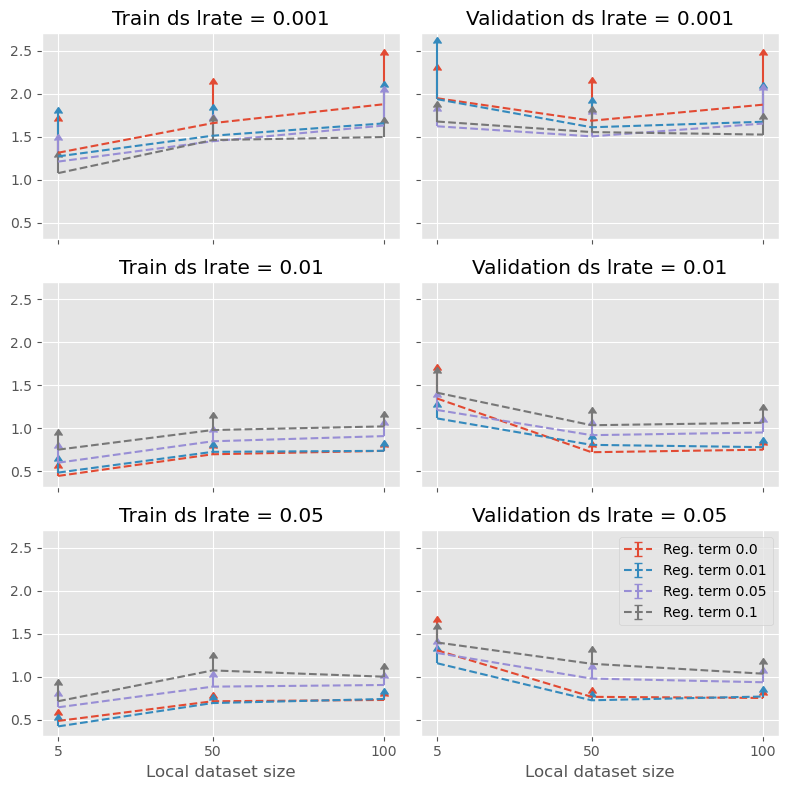

In [164]:
titles = ['Train ds', 'Validation ds']

fig, axes = plt.subplots(len(lrates), 2, sharey=True, sharex=True, figsize=(8,8))

for i in range(len(lrates)):
    plot_list = mse_lrates[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ' lrate = ' + str(lrates[i]))

axes[-1,0].set_xlabel ('Local dataset size')
axes[-1,1].set_xlabel ('Local dataset size')
plt.legend()
fig.tight_layout()
plt.savefig("linreg_simpsons_ds_lrate.png")
plt.show()

### Pytorch - MLP

#### Toy ds

In [59]:
%%time
#-----------------Pytorch MLP - Mixed dataset-------------------#

lrates = [0.001, 0.01, 0.05]
mse_lrates = []

for lrate in lrates:
    # Create linear pytorch models
    models = [MLP_Torch(n_features, lr=lrate) for i in range(n_clusters*n_ds)]
    config['models'] = models
    config['noise_val'] = 1
    
    nodes_preds_list, mse_train_list, mse_val_list, dist_list = iter_params(config, mixed=True)
    mse_train, mse_std_train = mse_local_mean(mse_train_list)
    mse_val, mse_std_val = mse_local_mean(mse_val_list)
    
    mse_lrates.append( [(mse_train, mse_std_train), (mse_val, mse_std_val)] )

100%|█████████████████████████████████████████████████████████████████████████| 3/3 [05:31<00:00, 110.57s/it]

CPU times: user 1h 6min 24s, sys: 25.1 s, total: 1h 6min 49s
Wall time: 1h 8min 33s


In [60]:
import json

with open('mlp_toy_ds_lrate.json', 'w') as f:
    json.dump(mse_lrates, f)

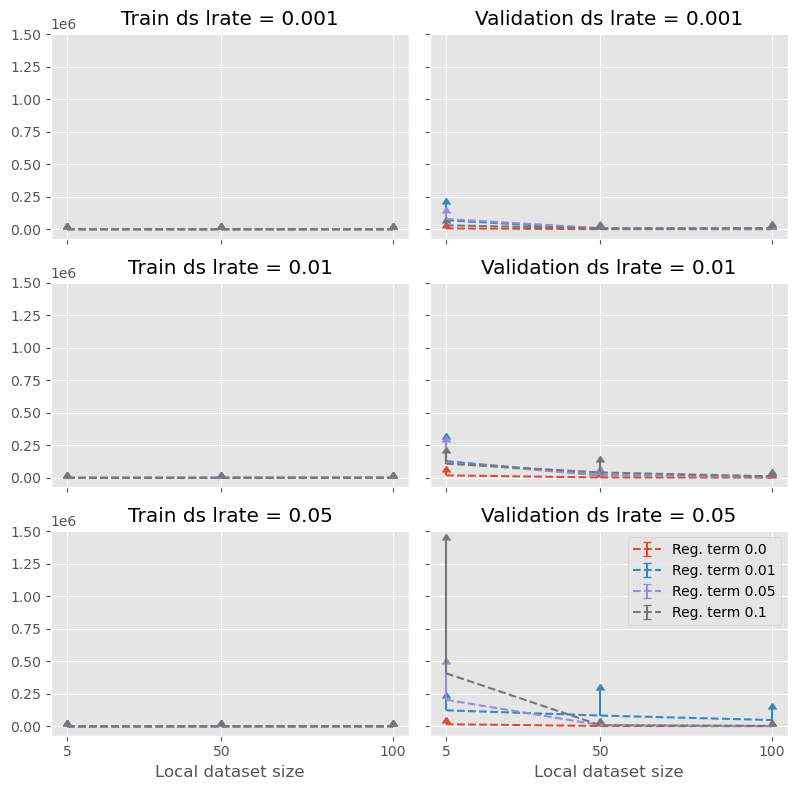

In [61]:
titles = ['Train ds', 'Validation ds']

fig, axes = plt.subplots(len(lrates), 2, sharey=True, sharex=True, figsize=(8,8))

for i in range(len(lrates)):
    plot_list = mse_lrates[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ' lrate = ' + str(lrates[i]))

axes[-1,0].set_xlabel ('Local dataset size')
axes[-1,1].set_xlabel ('Local dataset size')
plt.legend()
fig.tight_layout()
plt.savefig("mlp_toy_ds_lrate.png")
plt.show()

In [ ]:
%%time
#-----------------Pytorch Linear data augmentation-------------------#
   
# Create linear pytorch models
models = [Linreg_Torch_aug(n_features) for i in range(n_clusters*n_ds)]
config['models'] = models

pred_test_list, mse_local_list, dist_list = iter_params(config)

# Plot MSE
mse, mse_std = mse_local_mean(mse_local_list)
plot_mse(mse, mse_std, reg_term_list, n_samples_list)

### Sklearn

In [ ]:
%%time
#-----------------Sklearn LinReg-------------------#
   
# Create linear pytorch models
models = [Linreg_Sklearn() for i in range(n_clusters*n_ds)]
config['models'] = models

pred_test_list, mse_local_list, dist_list = iter_params(config)

# Plot MSE
mse, mse_std = mse_local_mean(mse_local_list)
plot_mse(mse, mse_std, reg_term_list, n_samples_list)

In [ ]:
%%time
#-----------------Sklearn LinReg - Mixed dataset-------------------#
   
# Create linear pytorch models
models = [Linreg_Sklearn() for i in range(n_clusters*n_ds)]
config['models'] = models

pred_test_list, mse_local_list, dist_list = iter_params(config, mixed=True)

# Plot MSE
mse, mse_std = mse_local_mean(mse_local_list)
plot_mse(mse, mse_std, reg_term_list, n_samples_list)

In [ ]:
%%time
#-----------------DT-------------------#

noise_vals = [0, 0.5, 1]
mse_noise = []

for noise_val in noise_vals:
    # Create linear pytorch models
    models = [DTReg(max_depth=3) for i in range(n_clusters*n_ds)]
    config['models'] = models
    config['noise_val'] = noise_val
    
    nodes_preds_list, mse_train_list, mse_val_list, dist_list = iter_params(config)
    mse_train, mse_std_train = mse_local_mean(mse_train_list)
    mse_val, mse_std_val = mse_local_mean(mse_val_list)
    
    mse_noise.append( [(mse_train, mse_std_train), (mse_val, mse_std_val)] )

In [ ]:
titles = ['MSE on a train dataset', 'MSE on a val dataset']

fig, axes = plt.subplots(len(noise_vals), 2, sharey=True, sharex=True, figsize=(8,8))

for i in range(len(noise_vals)):
    plot_list = mse_noise[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ' noise = ' + str(noise_vals[i]))

axes[0,0].set_ylabel ('MSE')
axes[1,0].set_ylabel ('MSE')
axes[2,0].set_ylabel ('MSE')

axes[-1,0].set_xlabel ('Local dataset size')
axes[-1,1].set_xlabel ('Local dataset size')
plt.legend()
fig.tight_layout()
plt.savefig("DT_syn_ds.png")
plt.show()

In [ ]:
%%time
#-----------------DT - Mixed dataset-------------------#

max_depths = [3, 10, 20]
mse_lrates = []

for max_depth in max_depths:
    # Create linear pytorch models
    models = [DTReg(max_depth=max_depth) for i in range(n_clusters*n_ds)]
    config['models'] = models
    config['noise_val'] = 1
    
    nodes_preds_list, mse_train_list, mse_val_list, dist_list = iter_params(config, mixed=True)
    mse_train, mse_std_train = mse_local_mean(mse_train_list)
    mse_val, mse_std_val = mse_local_mean(mse_val_list)
    
    mse_lrates.append( [(mse_train, mse_std_train), (mse_val, mse_std_val)] )

In [ ]:
titles = ['Train dataset', 'Val dataset']

fig, axes = plt.subplots(len(lrates), 2, sharey=True, sharex=True, figsize=(8,8))

for i in range(len(lrates)):
    plot_list = mse_lrates[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ', max depth = ' + str(max_depths[i]))

axes[-1,0].set_xlabel ('Local dataset size')
axes[-1,1].set_xlabel ('Local dataset size')
plt.legend()
fig.tight_layout()
plt.savefig("DT_toy_ds.png")
plt.show()

## Models in a Graph are of one type within a cluster

In [43]:
%%time
#-----------------Mix [pytorch linreg, DT, pytorch MLP] NOISE-------------------#

noise_vals = [0, 0.5, 1]
mse_noise = []

for noise_val in noise_vals:
    # Create linear models
    models = [Linreg_Torch(n_features) for i in range(n_ds)] + [DTReg(max_depth=3) for i in range(n_ds)] + [MLP_Torch(n_features) for i in range(n_ds)]
    config['models'] = models
    config['noise_val'] = noise_val
    
    nodes_preds_list, mse_train_list, mse_val_list, dist_list = iter_params(config)
    mse_train, mse_std_train = mse_local_mean(mse_train_list)
    mse_val, mse_std_val = mse_local_mean(mse_val_list)
    
    mse_noise.append( [(mse_train, mse_std_train), (mse_val, mse_std_val)] )

100%|██████████████████████████████████████████████████████████████████████| 3/3 [2:28:54<00:00, 2978.22s/it]

CPU times: user 1h 38s, sys: 16.5 s, total: 1h 54s
Wall time: 4h 48min 17s


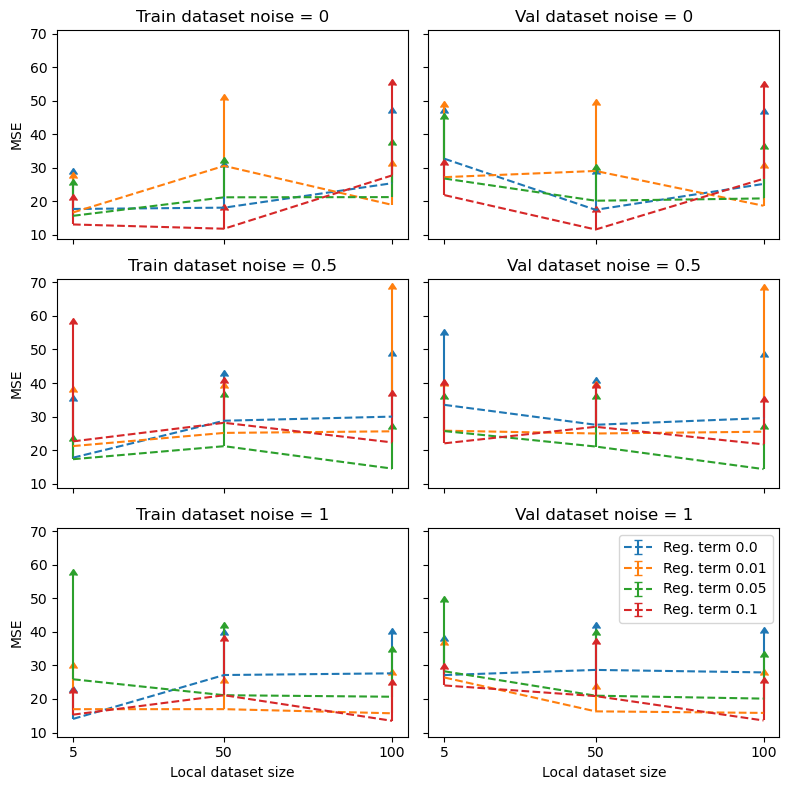

In [44]:
titles = ['Train dataset', 'Val dataset']

fig, axes = plt.subplots(len(noise_vals), 2, sharey=True, sharex=True, figsize=(8,8))

for i in range(len(noise_vals)):
    plot_list = mse_noise[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ' noise = ' + str(noise_vals[i]))

axes[0,0].set_ylabel ('MSE')
axes[1,0].set_ylabel ('MSE')
axes[2,0].set_ylabel ('MSE')

axes[-1,0].set_xlabel ('Local dataset size')
axes[-1,1].set_xlabel ('Local dataset size')
plt.legend()
fig.tight_layout()
plt.savefig("mix_syn_ds.png")
plt.show()

In [45]:
%%time
#-----------------Mix [pytorch linreg, DT, pytorch MLP] LRATE-------------------#


lrates = [0.001, 0.01, 0.05]
mse_lrates = []

for lrate in lrates:
    # Create linear pytorch models
    models = [Linreg_Torch(n_features, lr=lrate) for i in range(n_ds)] + [DTReg(max_depth=3) for i in range(n_ds)] + [MLP_Torch(n_features, lr=lrate) for i in range(n_ds)]
    config['models'] = models
    config['noise_val'] = 1
    
    nodes_preds_list, mse_train_list, mse_val_list, dist_list = iter_params(config)
    mse_train, mse_std_train = mse_local_mean(mse_train_list)
    mse_val, mse_std_val = mse_local_mean(mse_val_list)
    
    mse_lrates.append( [(mse_train, mse_std_train), (mse_val, mse_std_val)] )

100%|█████████████████████████████████████████████████████████████████████████| 3/3 [05:16<00:00, 105.40s/it]

CPU times: user 59min 16s, sys: 26.4 s, total: 59min 43s
Wall time: 1h 1min 27s


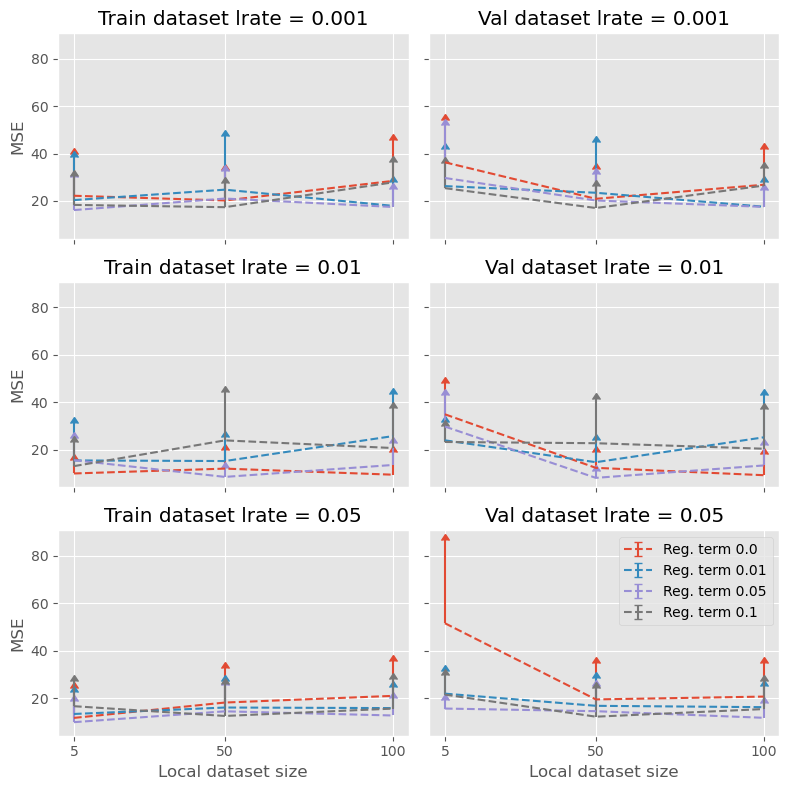

In [48]:
titles = ['Train dataset', 'Val dataset']

fig, axes = plt.subplots(len(noise_vals), 2, sharey=True, sharex=True, figsize=(8,8))

for i in range(len(lrates)):
    plot_list = mse_lrates[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ' lrate = ' + str(lrates[i]))

axes[0,0].set_ylabel ('MSE')
axes[1,0].set_ylabel ('MSE')
axes[2,0].set_ylabel ('MSE')

axes[-1,0].set_xlabel ('Local dataset size')
axes[-1,1].set_xlabel ('Local dataset size')
plt.legend()
fig.tight_layout()
plt.savefig("mix_syn_ds_lrate.png")
plt.show()

In [ ]:
%%time
#-----------------Mix[pytorch linreg, DT, pytorch MLP] - MIXED DATA-------------------#

lrates = [0.001, 0.01, 0.05]
mse_lrates = []

for lrate in lrates:
    # Create linear pytorch models
    models = [Linreg_Torch(n_features, lr=lrate) for i in range(n_ds)] + [DTReg(max_depth=3) for i in range(n_ds)] + [MLP_Torch(n_features, lr=lrate) for i in range(n_ds)]
    config['models'] = models
    config['noise_val'] = 1
    
    nodes_preds_list, mse_train_list, mse_val_list, dist_list = iter_params(config, mixed=True)
    mse_train, mse_std_train = mse_local_mean(mse_train_list)
    mse_val, mse_std_val = mse_local_mean(mse_val_list)
    
    mse_lrates.append( [(mse_train, mse_std_train), (mse_val, mse_std_val)] )

In [ ]:
titles = ['MSE on a train dataset', 'MSE on a val dataset']

fig, axes = plt.subplots(len(lrates), 2, sharey=True, sharex=True, figsize=(8,8))

for i in range(len(lrates)):
    plot_list = mse_lrates[i]
    axs = axes[i]

    for ax, data, title in zip(axs, plot_list, titles):
        mse = data[0]
        mse_std = data[1]
        plot_mse(mse, mse_std, reg_term_list, n_samples_list)
        ax.set_title(title + ' lrate = ' + str(lrates[i]))

axes[-1,0].set_xlabel ('Local dataset size')
axes[-1,1].set_xlabel ('Local dataset size')
plt.legend()
fig.tight_layout()
plt.savefig("mix_toy_ds.png")
plt.show()

## Effect of edge weights on loss

In [ ]:
# mse_node_list = []

# for pred_test in pred_test_list:
#     mse_node_array = np.zeros((repeat_times, nnodes, nnodes))
#     for i in range(len(pred_test)):
#         mse_node, _ = compute_mse(pred_test[i])
#         mse_node_array[i] = mse_node
#     mse_node_list.append(mse_node_array)

# mse_node_mean = [np.mean(e, axis=0) for e in mse_node_list]
# mse_node_std = [np.std(e, axis=0) for e in mse_node_list]